In [1]:
import numpy as np
%matplotlib inline 
import pandas as pd
import tensorflow as tf
from IPython.display import display, Image
import cv2
from PIL import Image
from tqdm import tqdm
from keras.applications.vgg19 import VGG19
from keras.utils.vis_utils import plot_model
import gc
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
import math
from sklearn.metrics import mean_squared_error, mean_absolute_error

                          avg cpu
timestamp                        
2017-01-01 00:00:00  1.229569e+06
2017-01-01 00:05:00  1.211322e+06
2017-01-01 00:10:00  1.206635e+06
2017-01-01 00:15:00  1.190369e+06
2017-01-01 00:20:00  1.180992e+06


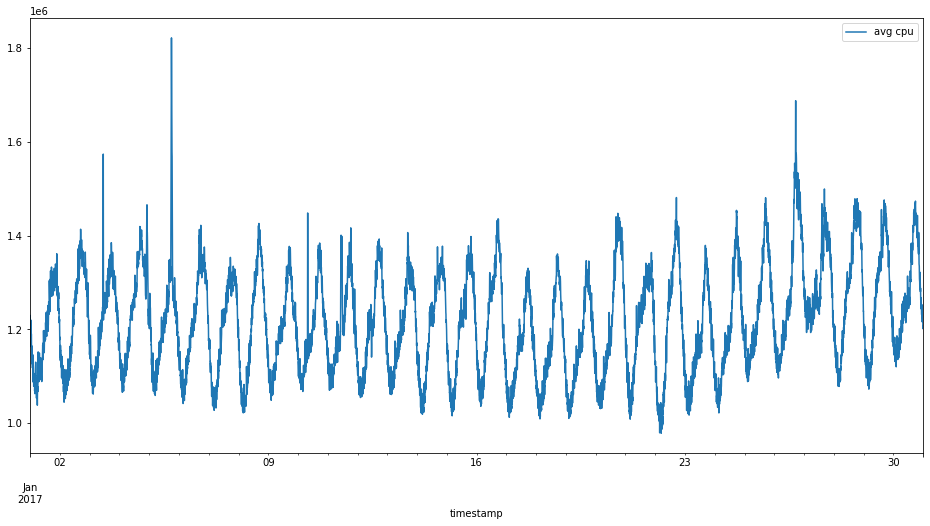

In [2]:
# let's load the dataset
df = pd.read_csv("./azure.csv")
df['timestamp'] = pd.to_datetime(df['timestamp'])
df = df.set_index('timestamp')
df.drop('min cpu', inplace=True, axis=1)
df.drop('max cpu', inplace=True, axis=1)
print(df.head())
df.plot(figsize=(16,8))
plt.show()

In [3]:
# create train test split
train_length = round(len(df)*0.8)
test_length = len(df) - train_length
train = df.iloc[0:train_length]
test = df.iloc[train_length:]

In [4]:
train_mean = train.mean()
train_std = train.std()

train = (train - train_mean) / train_std
test = (test - train_mean) / train_std

In [5]:
# let's scale the values of the dataset
scaler = MinMaxScaler(feature_range = (0,1)) #transform features by scaling each feature to a given range
train_scaled = pd.DataFrame(scaler.fit_transform(train), columns=df.columns)
test_scaled = pd.DataFrame(scaler.fit_transform(test), columns=df.columns)

In [6]:
# let's build another scaler for just one column and not the three
new_scaler = MinMaxScaler(feature_range = (0,1))
train_scaled = pd.DataFrame(new_scaler.fit_transform(train["avg cpu"].to_numpy().reshape(-1,1)), columns=["avg cpu"])
test_scaled = pd.DataFrame(new_scaler.fit_transform(test["avg cpu"].to_numpy().reshape(-1,1)), columns=['avg cpu'])

In [20]:
def train_generator(dataset, n_lags=1):
    dataX, dataY = [], []
    for i in range(len(dataset) - n_lags - 1):
        a = dataset.iloc[i:(i+n_lags)].to_numpy()
        dataX.append(a)
        dataY.append(dataset.iloc[i + n_lags].to_numpy())

    dataX = np.array(dataX)
    dataY = np.array(dataY)

    new_dataX = np.empty([dataX.shape[0], dataX.shape[1]])
    for i in range(len(dataX)) : 
        for j in range(dataX.shape[1]) :
            new_dataX[i][j] = dataX[i][j][0]

    new_dataY = np.empty(dataY.shape[0])
    for i in range(len(dataY)) : 
        new_dataY[i] = dataY[i][0]

    return (np.array(new_dataX), np.array(new_dataY))

In [21]:
TIME_STEPS = 100 
X_train, y_train = train_generator(train_scaled, n_lags = TIME_STEPS)
X_test_scaled, y_test_scaled = train_generator(test_scaled, n_lags=TIME_STEPS)
X_test, y_test = train_generator(test, n_lags=TIME_STEPS)

In [22]:
print(X_train.shape)
print(X_test.shape)
print(y_train.shape)
print(y_train[0])

(6811, 100)
(1627, 100)
(6811,)
0.1648758125752326


# Let's build a dense network and test it out

In [23]:
# define the keras model
model_NN = tf.keras.Sequential()
model_NN.add(tf.keras.layers.Dense(32, input_dim=100, activation='relu'))
model_NN.add(tf.keras.layers.Dense(32, activation='relu'))
model_NN.add(tf.keras.layers.Dense(1, activation='sigmoid'))


In [24]:
model_NN.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 32)                3232      
                                                                 
 dense_1 (Dense)             (None, 32)                1056      
                                                                 
 dense_2 (Dense)             (None, 1)                 33        
                                                                 
Total params: 4,321
Trainable params: 4,321
Non-trainable params: 0
_________________________________________________________________


In [ ]:
new_X_train = np.empty([X_train.shape[0], X_train.shape[1]])
for i in range(len(X_train)) : 
    for j in range(X_train.shape[1]) :
        new_X_train[i][j] = X_train[i][j][1]


new_X_test = np.empty([X_test.shape[0], X_test.shape[1]])
for i in range(len(X_test)) : 
    for j in range(X_test.shape[1]) :
        new_X_test[i][j] = X_test[i][j][1]


new_X_test_scaled = np.empty([X_test_scaled.shape[0], X_test_scaled.shape[1]])
for i in range(len(X_test_scaled)) : 
    for j in range(X_test_scaled.shape[1]) :
        new_X_test_scaled[i][j] = X_test_scaled[i][j][1]

In [ ]:
new_y_train = np.empty(y_train.shape[0])
for i in range(len(y_train)) : 
    new_y_train[i] = y_train[i][1]


new_y_test = np.empty(y_test.shape[0])
for i in range(len(y_test)) : 
    new_y_test[i] = y_test[i][1]

In [ ]:
print(new_X_train.shape)
print(new_X_test.shape)
print(new_X_test_scaled.shape)
print(new_y_train.shape)
print(new_y_test.shape)

In [25]:
model_NN.compile(loss="mean_absolute_error", optimizer= tf.keras.optimizers.Adam())

In [26]:
es = tf.keras.callbacks.EarlyStopping( monitor='val_loss', patience=8, verbose=1, restore_best_weights=True)
lr_red = tf.keras.callbacks.ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=4, verbose=1, min_lr=0.0000001,)

In [27]:
callbacks = [es, lr_red]
history = model_NN.fit(X_train, y_train, epochs=200, validation_split=0.25, batch_size=256, verbose=1,
                    shuffle=False,
                    callbacks = callbacks)
# would be logical to train model on mutltiple batch sizes

Epoch 1/200
20/20 [==============================] - 0s 6ms/step - loss: 0.1532 - val_loss: 0.1504 - lr: 0.0010
Epoch 2/200
20/20 [==============================] - 0s 2ms/step - loss: 0.1183 - val_loss: 0.1280 - lr: 0.0010
Epoch 3/200
20/20 [==============================] - 0s 2ms/step - loss: 0.0958 - val_loss: 0.1019 - lr: 0.0010
Epoch 4/200
20/20 [==============================] - 0s 2ms/step - loss: 0.0758 - val_loss: 0.0854 - lr: 0.0010
Epoch 5/200
20/20 [==============================] - 0s 2ms/step - loss: 0.0673 - val_loss: 0.0758 - lr: 0.0010
Epoch 6/200
20/20 [==============================] - 0s 2ms/step - loss: 0.0625 - val_loss: 0.0682 - lr: 0.0010
Epoch 7/200
20/20 [==============================] - 0s 2ms/step - loss: 0.0576 - val_loss: 0.0620 - lr: 0.0010
Epoch 8/200
20/20 [==============================] - 0s 2ms/step - loss: 0.0534 - val_loss: 0.0580 - lr: 0.0010
Epoch 9/200
20/20 [==============================] - 0s 2ms/step - loss: 0.0505 - val_loss: 0.0550 - lr:

In [ ]:
# sayyiv le modele when done
model_NN.save('./test_model_NN')

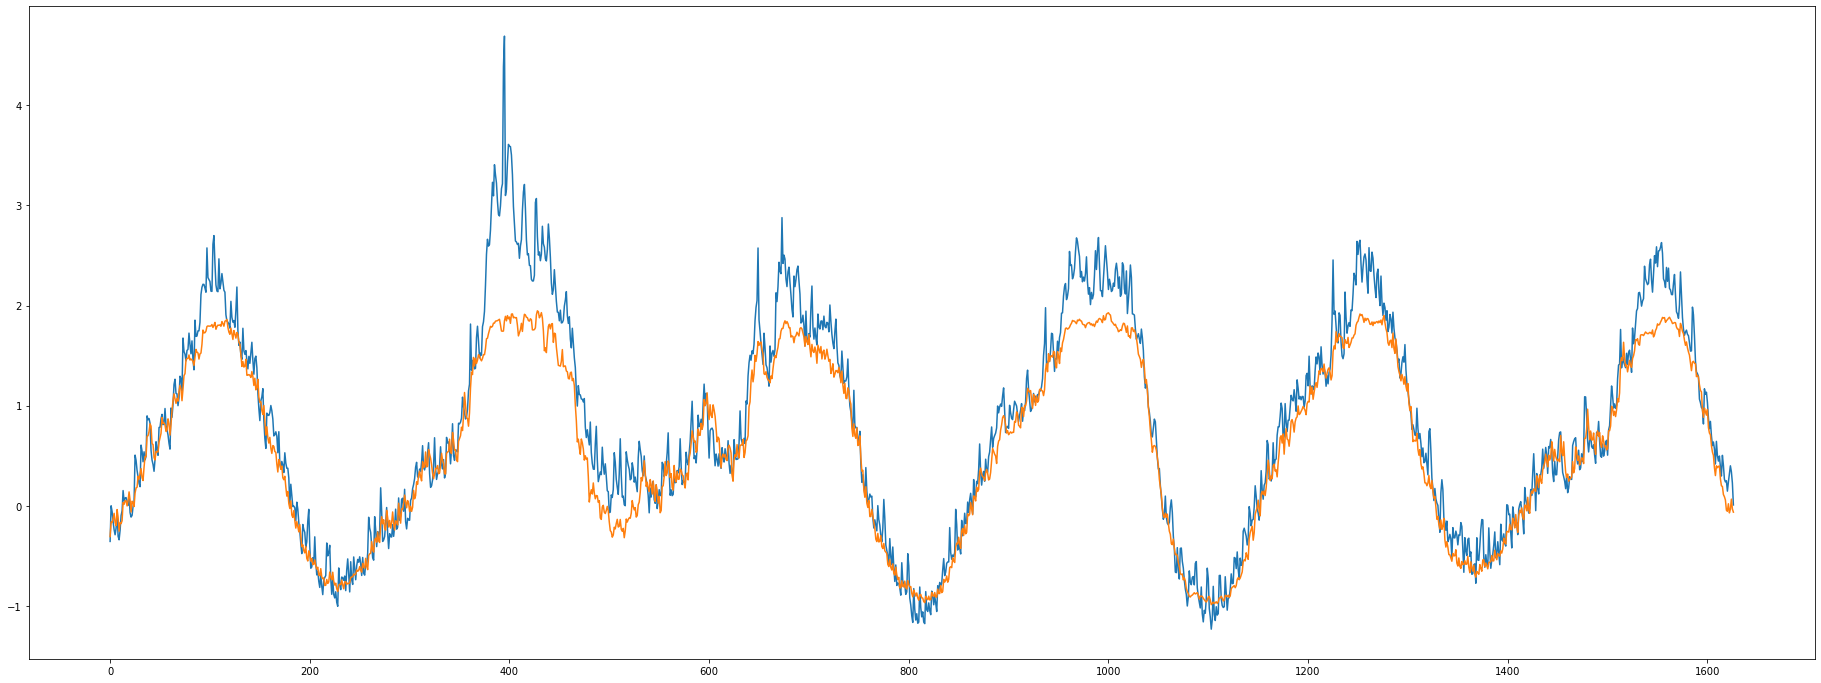

In [29]:
preds = model_NN.predict(X_test_scaled)
preds = scaler.inverse_transform(preds)
plt.rcParams["figure.figsize"] = (32,12)
TestY = pd.DataFrame(y_test, columns=['avg_cpu'])
PredY = pd.DataFrame(preds, columns=['avg_cpu'])

plot_avg = plt.figure(1)
plt.plot(TestY['avg_cpu'])
plt.plot(PredY['avg_cpu'])
plt.show()

In [ ]:
#-----------------------------------------------------------
# LETS CHECK HOW GOOD THE MODEL PERFORMED
#-----------------------------------------------------------
testScore_1 = math.sqrt(mean_squared_error(new_y_test[:], preds[:]))
print('Test Score: %.2f RMSE' % (testScore_1))

testScore_2 = math.sqrt(mean_absolute_error(new_y_test[:], preds[:]))
print('Test Score: %f MAE' % (testScore_2))

testScore_3 = np.mean(np.abs(preds - new_y_test)/np.abs(new_y_test)*100)
print('Test Score: %f MAPE' % (testScore_3))

# Let's build an LSTM model

In [ ]:
# let's build the lstm model
# return sequences?? -> 
model_lstm = tf.keras.models.Sequential()
model_lstm.add(tf.keras.layers.LSTM(512,input_shape=(X_train.shape[1], 1),return_sequences=True))
model_lstm.add(tf.keras.layers.LSTM(512, return_sequences=False))
model_lstm.add(tf.keras.layers.Dense(1))
model_lstm.summary()

In [ ]:
model_lstm.compile(loss="mean_absolute_error", optimizer= tf.keras.optimizers.Adam())

In [ ]:
es = tf.keras.callbacks.EarlyStopping( monitor='val_loss', patience=8, verbose=1, restore_best_weights=True)
lr_red = tf.keras.callbacks.ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=4, verbose=1, min_lr=0.0000001,)

In [ ]:
callbacks = [es, lr_red]
history = model_lstm.fit(new_X_train, new_y_train, epochs=200, validation_split=0.25, batch_size=256, verbose=1,
                    shuffle=False,
                    callbacks = callbacks)
# would be logical to train model on mutltiple batch sizes

In [ ]:
# sayyiv le modele when done
model_lstm.save('./test_model_LSTM')

In [ ]:
# let's load the model
import keras
model_lstm = keras.models.load_model('./test_model_LSTM')

In [ ]:
new_X_test_scaled.shape

In [ ]:
preds = model_lstm.predict(new_X_test_scaled)
preds = new_scaler.inverse_transform(preds)
plt.rcParams["figure.figsize"] = (32,12)
TestY = pd.DataFrame(new_y_test, columns=['avg_cpu'])
PredY = pd.DataFrame(preds, columns=['avg_cpu'])

plot_avg = plt.figure(1)
plt.plot(TestY['avg_cpu'])
plt.plot(PredY['avg_cpu'])
plt.show()

In [ ]:
#-----------------------------------------------------------
# LETS CHECK HOW GOOD THE MODEL PERFORMED
#-----------------------------------------------------------
testScore_1 = math.sqrt(mean_squared_error(new_y_test[:], preds[:]))
print('Test Score: %.2f RMSE' % (testScore_1))

testScore_2 = math.sqrt(mean_absolute_error(new_y_test[:], preds[:]))
print('Test Score: %f MAE' % (testScore_2))

testScore_3 = np.mean(np.abs(preds - new_y_test)/np.abs(new_y_test)*100)
print('Test Score: %f MAPE' % (testScore_3))

# Let's try to implement a GRU

In [ ]:
"""
The key difference between GRU and LSTM is that GRU's 
bag has two gates that are reset and update while LSTM has three 
gates that are input, output, forget. GRU is less complex than LSTM 
because it has less number of gates. If the dataset is small then GRU 
is preferred otherwise LSTM for the larger dataset.
"""

In [ ]:
# let's build the lstm model
# return sequences?? -> 
model_GRU = tf.keras.models.Sequential()
model_GRU.add(tf.keras.layers.GRU(512,input_shape=(X_train.shape[1], 1),return_sequences=True))
model_GRU.add(tf.keras.layers.GRU(512, return_sequences=False))
model_GRU.add(tf.keras.layers.Dense(1))
model_GRU.summary()

In [ ]:
model_GRU.compile(loss="mean_absolute_error", optimizer= tf.keras.optimizers.Adam())

In [ ]:
es = tf.keras.callbacks.EarlyStopping( monitor='val_loss', patience=8, verbose=1, restore_best_weights=True)
lr_red = tf.keras.callbacks.ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=4, verbose=1, min_lr=0.0000001,)

In [ ]:
callbacks = [es, lr_red]
history = model_GRU.fit(new_X_train, new_y_train, epochs=200, validation_split=0.25, batch_size=256, verbose=1,
                    shuffle=False,
                    callbacks = callbacks)
# would be logical to train model on mutltiple batch sizes

In [ ]:
# let's load the model
import keras
model_GRU = keras.models.load_model('./test_model_GPU')

In [ ]:
preds = model_GRU.predict(new_X_test_scaled)
preds = new_scaler.inverse_transform(preds)
plt.rcParams["figure.figsize"] = (32,12)
TestY = pd.DataFrame(new_y_test, columns=['avg_cpu'])
PredY = pd.DataFrame(preds, columns=['avg_cpu'])

plot_avg = plt.figure(1)
plt.plot(TestY['avg_cpu'])
plt.plot(PredY['avg_cpu'])
plt.show()

In [ ]:
# sayyiv le modele when done
model_GRU.save('./test_model_GPU')

In [ ]:
#-----------------------------------------------------------
# LETS CHECK HOW GOOD THE MODEL PERFORMED
#-----------------------------------------------------------
testScore_1 = math.sqrt(mean_squared_error(new_y_test[:], preds[:]))
print('Test Score: %.2f RMSE' % (testScore_1))

testScore_2 = math.sqrt(mean_absolute_error(new_y_test[:], preds[:]))
print('Test Score: %f MAE' % (testScore_2))

testScore_3 = np.mean(np.abs(preds - new_y_test)/np.abs(new_y_test)*100)
print('Test Score: %f MAPE' % (testScore_3))